In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from importlib import reload

import torch
import numpy as np
import pandas as pd
import sciplots as plots

from src import main
from src.utils import analysis, clustering
from src.utils.utils import open_config, overlap

reload(plots.base)
reload(plots.single_plots)
reload(plots)
reload(analysis)
reload(main)
reload(clustering)

import sciplots as plots
from src.utils.data import DarkDataset
from src.utils import analysis, plot_config

In [3]:
def tests_format(data):
    if not isinstance(data.index, pd.MultiIndex):
        return data['net'].to_numpy()[np.newaxis]

    new_data = np.empty([len(level) for level in data.index.levels[1:]], dtype=object)

    for shape, vals in data.groupby(level=data.index.names[1:])['net'].apply(list).items():
        new_data[*([shape] if isinstance(shape, int) else shape)] = vals

    return np.array(new_data.tolist(), dtype=object)

In [4]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = os.path.join(config['output']['plots-directory'], 'final_plots')
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)
# colours = np.array([*plot_config.BAHAMAS[:2], 'k', plot_config.BAHAMAS[-1]])
colours = np.array(plot_config.BAHAMAS)

In [5]:
dataset = DarkDataset(
    config['data']['data-dir'],
    [
        'bahamas_cdm_shear',
        'bahamas_0.1_shear',
        'bahamas_0.3_shear',
        'bahamas_1_shear',
    ],
    [],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
dataset.high_dim.shape

(14400, 2, 100, 100)

In [6]:
with open('../data/shear_8.pkl', 'rb') as file:
    data = pickle.load(file)

data['net'] = np.empty_like(data['net_path'], dtype=object)

for i, net_path in enumerate(data['net_path']):
    data.loc[i, 'net'] = torch.load(net_path, map_location='cpu')

In [7]:
nets = tests_format(data)
nets = nets.reshape(len(nets), -1)
nets = np.array(np.delete(nets, np.argwhere(nets == None)[0, 1], axis=-1).tolist())
nets.shape

(3, 7, 3)

In [ ]:
nets = np.concat((nets, np.empty((*nets.shape[:-1], 1), dtype=object)), axis=-1)
nets[0, -1] = nets[0, 0][3:]
nets[1, -1] = nets[1, 0][3:]
nets[0, 0] = nets[0, 0][:3]
nets[1, 0] = nets[1, 0][:3]
nets = np.array(nets.tolist(), dtype=object)
nets.shape

In [6]:
nets = np.array([
#     ['network_v10_mix_7', 'network_v10_mix_7.2', 'network_v10_mix_7.3'],
#     ['network_v10_mix_8', 'network_v10_mix_8.2', 'network_v10_mix_8.3'],
#     ['network_v10_shear_1', 'network_v10_shear_2', 'network_v10_shear_3'],
#     ['network_v10_shear_4', 'network_v10_shear_5', 'network_v10_shear_6'],
#     ['network_v14_shear_1', 'network_v14_shear_2', 'network_v14_shear_3'],
    ['network_v17_shear_6', 'network_v17_shear_6.2', 'network_v17_shear_6.3'],
], dtype=object)

for shape in np.ndindex(nets.shape):
    nets[*shape] = torch.load(os.path.join(states_dir, f'{nets[*shape]}.pth'), map_location='cpu')

nets.shape

(1, 3)

In [57]:
torch.manual_seed(0)
np.random.seed(0)
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fraction'],
    nets,
    dataset,
)

Loader Dataset Lengths: [11520, 2880]


/home/ethan_tregidga/PycharmProjects/Bayesian-DARKSKIES-Remote/venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: DeprecationWarning: Using forward pass from BaseLayer is deprecated, please inherit BaseSingleLayer or implement a custom forward method
  return forward_call(*args, **kwargs)


Prediction time: 1.014e+00 s
Prediction time: 1.005e+00 s
Prediction time: 1.010e+00 s
Loader Dataset Lengths: [11520, 2880]
Prediction time: 1.005e+00 s
Prediction time: 1.004e+00 s
Prediction time: 1.005e+00 s
Loader Dataset Lengths: [11520, 2880]
Prediction time: 1.007e+00 s
Prediction time: 9.997e-01 s
Prediction time: 9.987e-01 s
Loader Dataset Lengths: [11520, 2880]
Prediction time: 1.002e+00 s
Prediction time: 1.003e+00 s
Prediction time: 1.001e+00 s
Loader Dataset Lengths: [11520, 2880]
Prediction time: 1.010e+00 s
Prediction time: 1.003e+00 s
Prediction time: 1.004e+00 s
Loader Dataset Lengths: [11520, 2880]
Prediction time: 9.996e-01 s
Prediction time: 1.010e+00 s
Prediction time: 1.002e+00 s
Loader Dataset Lengths: [11520, 2880]
Prediction time: 1.012e+00 s
Prediction time: 9.960e-01 s
Prediction time: 1.001e+00 s
Loader Dataset Lengths: [11520, 2880]
Prediction time: 9.950e-01 s
Prediction time: 9.952e-01 s
Prediction time: 9.915e-01 s
Loader Dataset Lengths: [11520, 2880]


In [58]:
data_pred, distributions, new_distributions, grids, probs, quantiles = analysis.probs_distributions(
    quantile_values,
    predictions,
    nets,
    dataset,
)
quantiles = np.concat((quantiles, [quantiles[0] - quantiles[2], quantiles[3] - quantiles[0]]), axis=0)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

((3, 7, 3, 4), (3, 7, 4, 500), (3, 7, 500), (3, 7, 4, 500), (7, 3, 7, 4))

In [59]:
proj_vecs = np.empty(data_pred['latent'].shape[:-2], dtype=object)

for shape in np.ndindex(proj_vecs.shape):
    proj_vecs[*shape] = analysis.proj_all_inter_1d(data_pred['latent'][..., 1:][*shape], data_pred['targets'][*shape])

proj_vecs = np.array(proj_vecs.tolist(), dtype=object)
proj_vecs = proj_vecs.swapaxes(-2, -1)

bins = 500
cdfs = np.empty((*proj_vecs.shape, bins), dtype=float)

for shape in np.ndindex(proj_vecs.shape[:-1]):
    grid = np.mgrid[np.min(np.concat(proj_vecs[*shape])):np.max(np.concat(proj_vecs[*shape])):bins * 1j]
    cdfs[*shape] = [
        analysis.distribution_func(proj_vecs[*shape, 0], norm=True, cumulative=True, grid=grid)[1],
        analysis.distribution_func(proj_vecs[*shape, 1], norm=True, cumulative=True, grid=grid)[1],
    ]

emds = np.mean(np.subtract(cdfs[..., 0, :], cdfs[..., 1, :]), axis=-1)
overlaps = np.empty(proj_vecs.shape[:-1], dtype=float)

for shape in np.ndindex(overlaps.shape):
    overlaps[*shape] = overlap(*proj_vecs[*shape])

emd_means = np.mean(emds, axis=-3)
emd_stes = np.std(emds, axis=-3, ddof=1) / np.sqrt(emds.shape[-3])
overlap_means = np.mean(overlaps, axis=-3)
overlap_stes = np.std(overlaps, axis=-3, ddof=1) / np.sqrt(overlaps.shape[-3])
proj_vecs.shape, emd_means.shape

((3, 7, 3, 4, 3, 2), (3, 7, 4, 3))

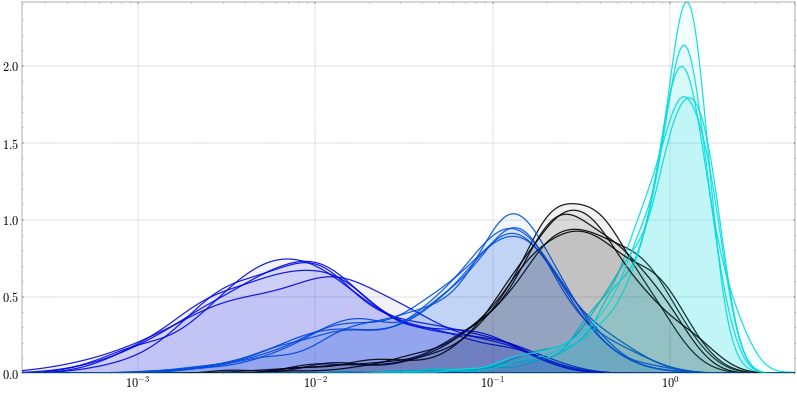

In [11]:
idx = (1, 3)
colours = np.array(plot_config.BAHAMAS[:2] + ['k'] + plot_config.BAHAMAS[3:])
plot = plots.PlotDistribution(
    nets[*idx, 0].transforms['targets'](distributions[*idx].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(colours, distributions.shape[-2]).tolist(),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8, 4),
)

In [12]:
quantiles.shape

(7, 2, 4, 4)

In [13]:
a = np.log10(quantiles)
a[-2] = a[0] - a[2]
a[-1] = a[3] - a[0]
np.log10(0.3)

np.float64(-0.5228787452803376)

In [191]:
pd.DataFrame(a[:, 0, 1, 2:3].swapaxes(0, 1), index=labels[2:3], columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

,50%,5%,16%,84%,95%,-,+
BAHAMAS-0.3,-0.50837,-0.87668,-0.73502,-0.27227,-0.14005,0.22665,0.2361


Architecture: CompactClusterEncoder
Description: Sims: ['bahamas_cdm_shear' 'bahamas_0.1_shear' 'bahamas_1_shear']
Unknown Sims: ['bahamas_0.3_shear']
Params: {'steps': 3, 'class_loss': 1, 'cluster_loss': 0.5, 'distance_loss': 0.5}
CDM Sigma: 0.001
Version: 3.8.0
Network: network_v17
Epoch: 150
Optimiser: AdamW
Scheduler: OneCycleLR
Args: (method: median, center_step: [1.0, 1.0, 1.0, 1.0], similarity_weight: 0, class_weight: 1, compact_weight: 0, distance_weight: 0.5, steps: 5, cluster_weight: 0.5)


,50%,5%,16%,84%,95%,-,+
BAHAMAS-0,0.00817,0.00216,0.00360,0.01589,0.03021,0.00457,0.00772
BAHAMAS-0.1,0.12202,0.02587,0.06005,0.21233,0.28956,0.06197,0.09031
BAHAMAS-0.3,0.33815,0.13333,0.19868,0.55057,0.73437,0.13947,0.21242
BAHAMAS-1,1.16950,0.71827,0.91653,1.42760,1.59486,0.25297,0.25810


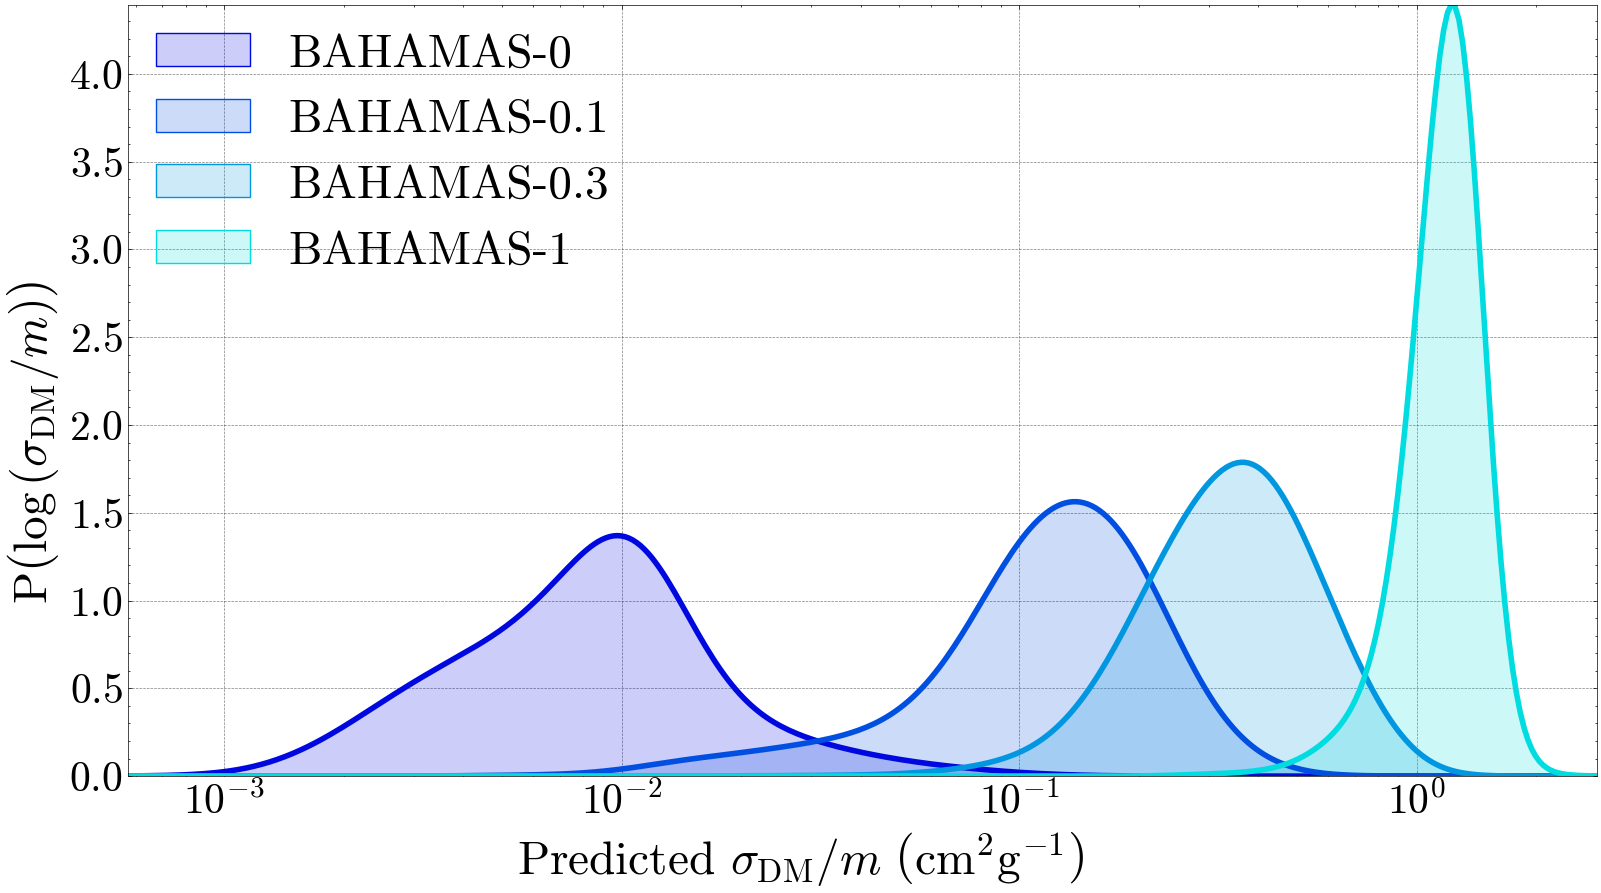

In [97]:
idx = (0, 3)
styles = np.array(['-'] * len(labels), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels.copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    # styles=styles,
    styles='-',
    labels=new_labels,
    colours=colours,
    frameon=False,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
    axis=True,
    cols=1,
    loc='upper left',
    # label_permute=[0, 1, 3, 2],
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
plot2.savefig(plots_dir, name='bahamas-0.1_distribution')
print(nets[*idx, 0])
pd.DataFrame(quantiles[:, *idx].swapaxes(0, 1), index=labels, columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

In [12]:
quantiles.shape

(7, 2, 4, 4)

In [25]:
quantiles[-2:, ..., 2].transpose(1, 0, 2).shape

(2, 2, 4)

In [43]:
len([*quantiles[-2:, 0].transpose(-1, 0, 1), *np.zeros((4, 4))])
len([*quantiles[0, 0].swapaxes(0, 1), *np.ones((4, 4)) * np.array([0.001, 0.1, 0.3, 1])[:, None]])
len([*plot_config.BAHAMAS, *['k'] * 4])
len([*labels, *['Target'] * 4])

8

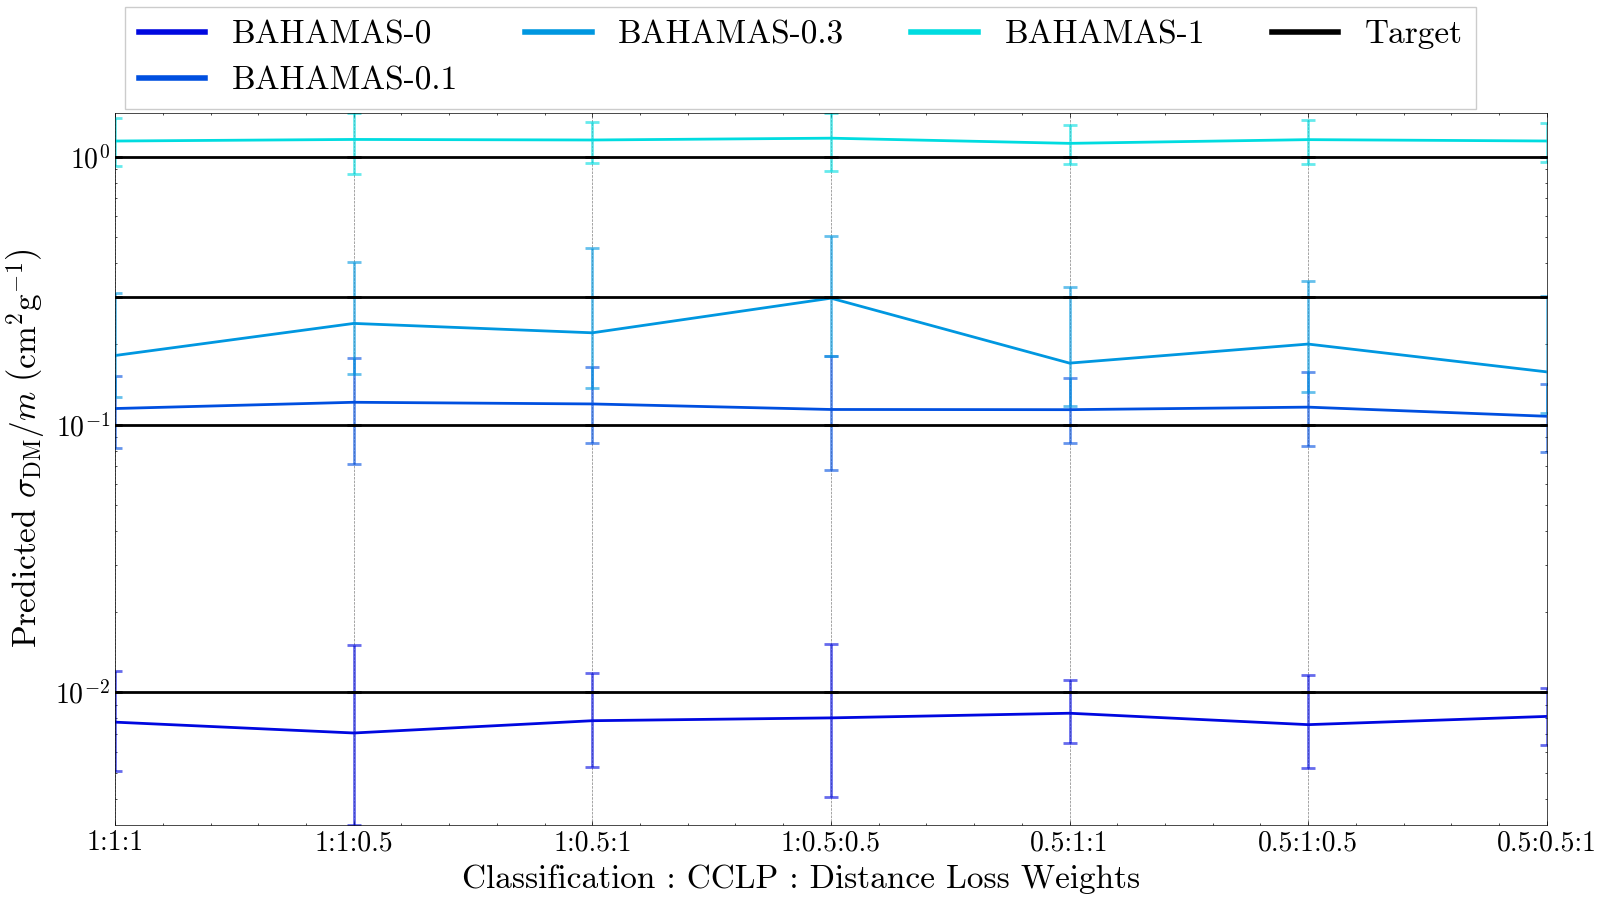

In [99]:
# x_data = np.array([3, 5, 7, 9])
idx = (2,)
x_data = np.array(['1:1:1', '1:1:0.5', '1:0.5:1', '1:0.5:0.5', '0.5:1:1', '0.5:1:0.5', '0.5:0.5:1'])
plot = plots.PlotPlots(
    x_data,
    [*quantiles[0, *idx].swapaxes(0, 1), *np.ones((4, len(x_data))) * np.array([0.01, 0.1, 0.3, 1])[:, None]],
    # [*quantiles[0, ..., 2], np.ones(len(x_data)) * 0.3],
    log_y=True,
    x_label='Classification : CCLP : Distance Loss Weights',
    y_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    styles='-',
    labels=[*labels, 'Target', *[''] * 3],
    # labels=[r'CDM $\sigma_{\rm DM}/m = 0.001$', r'CDM $\sigma_{\rm DM}/m = 0.003$', r'CDM $\sigma_{\rm DM}/m = 0.01$', 'Target'],
    y_error=[*quantiles[-2:, *idx].transpose(-1, 0, 1), *np.zeros((4, len(x_data)))],
    # y_error=[*quantiles[-2:, ..., 2].swapaxes(0, 1), np.zeros(len(x_data))],
    colours=[*plot_config.BAHAMAS, *['k'] * 4],
    # colours=[*plot_config.BAHAMAS[1:], 'k'],
)